In [1]:
import json
import os
import pandas as pd
import nltk
import gensim as gs
import pickle
import pyLDAvis.gensim
import math

C:\Users\prady\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [2]:
# Reading in the preprocessed reviews from Task 1
restaurant_review = pd.read_csv("../restaurant_reviews_processed.csv", sep=":")
restaurant_review["categories"] = restaurant_review["categories"].apply(lambda x: set(eval(x)))
restaurant_review["review"] = restaurant_review["review"].apply(eval)

In [3]:
#Manually created list of 15 cuisines from the categories. Chose these from the ones with the most reviews.
cuisines = {"American (New)", "Mexican", "Italian", "Steakhouses", "Japanese", "Chinese", "Sushi Bars", "Seafood", "Fast Food", "Thai" ,"Asian Fusion", "Mediterranean", "Barbeque", "French", "Cafes"}

In Task 1 we saw that using _lift_ to caculate the relevance of a word when categorised by cuisine generated at least one topic that was distinctly representative of the cuisine. Hence I have decided to use the same method to describe a cuisine. Instead of using a separate model for each cuisine where 1 topic describes the cuisine I have attempted to generate 15 topics for a set of reviews that pertain to 15 cuisines and I am hoping that I will be able to get 1 topic per cuisine.

In [4]:
#Creating a sample set of reviews by sampling 10000 rows from each cuisine resulting in a set of 15 * 10000 rows.
rows_by_cuisine = []
for c in cuisines:
    rows_by_cuisine.append(restaurant_review[restaurant_review["categories"].map(lambda x: c in x)].sample(10000))

training_set = pd.concat(rows_by_cuisine)
training_set

,Unnamed: 0,user_id,stars_review,date,review,business_id,categories,city,review_count,name,state,stars_restaurant
143202,238659,24lxxffqEYP7K_Y2WN4r7w,5,2011-01-29,"[times, impressed, quality, care, presentation...",5FE1Y9cZ-YOQA943nTi7cA,"{Restaurants, American (New)}",Las Vegas,323,Rosemary's Restaurant,NV,4.5
96884,160377,K9dSPbFhxbLPNZBTp7uOMg,5,2014-05-14,"[cutest, freshest, brunch, spot, loved, notes,...",24V8QQWO6VaVggHdxjQQ_A,"{Bars, Wine Bars, Nightlife, Restaurants, Amer...",Scottsdale,263,Arcadia Farms Cafe,AZ,4.0
562059,899924,euNiN-ltMiB1UhQOik5uvQ,5,2014-03-13,"[group, phoenix, weekend, dodger, spring, trai...",Xq9tkiHhyN_aBFswFeGLvA,"{Burgers, Bars, Nightlife, Restaurants, Americ...",Phoenix,575,The Arrogant Butcher,AZ,4.0
540863,869333,UatPBI38SfO3XUBFsrTLVg,4,2014-07-05,"[updating, review, grabbed, takeout, nacho, da...",aYAlzKHwXQn6JNLweRnZjQ,"{Sports Bars, Mexican, Bars, Nightlife, Restau...",Las Vegas,362,Nacho Daddy,NV,3.5
175044,294545,ehSyEkVq1lnMf1dM6umF9w,5,2012-12-18,"[vbar, weekend, usual, notch, boys, table, jor...",AHzxXDQs4y5htkgD5jIpQA,"{Bars, Lounges, Nightlife, Restaurants, Americ...",Las Vegas,137,V Bar,NV,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...
665417,1060595,o6hjcO1p6Zp439Bt1hoJiw,4,2014-06-30,"[dinner, fiancé, recommended, friend, worried,...",rO3saNBRU2Pg16RyfEP6-g,"{Restaurants, Mexican}",Phoenix,170,Otro Cafe,AZ,4.0
628763,1002207,ZsC2L07UPPyIRqQbxjZspw,5,2012-06-04,"[heaven, lovely, clean, facility, super, fresh...",SIY2d48njDU3ljfmOyadZg,"{Restaurants, Mexican}",Las Vegas,11,Zabas Mexican Grill,NV,3.5
369401,588726,QWfVFskBxySzAUMrq0_XIw,4,2013-03-14,"[decided, chance, groupon, half, picnic, table...",Pq91OM8RI_Rcr6PpXQajsw,"{Bars, Nightlife, Restaurants, Mexican}",Peoria,114,Salty Senorita,AZ,2.5
604038,963087,CRa4i13Jd2TIAY7M2CIxXQ,1,2014-06-08,"[taco, awesome, craving, taco, thought, cheese...",qrLqx4oBeR2gNDE873bUHw,"{Food, Mexican, Restaurants, Do-It-Yourself Food}",Mesa,14,Taco 4U Mexican Food,AZ,3.0


In [16]:
def create_lda_model(reviews, topic_count):
    dictionary = gs.corpora.Dictionary(reviews)
    corpus = [dictionary.doc2bow(text) for text in reviews]
    ldamodel = gs.models.ldamodel.LdaModel(corpus, num_topics = topic_count, id2word=dictionary, passes=10, alpha="auto")
    return (ldamodel, corpus, dictionary)

In [17]:
(model, corpus, dictionary) = create_lda_model(training_set["review"], 15)

In [18]:
lda_d = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_d)

C:\Users\prady\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


The topics were not segregated by cuisines as I had hoped. So I am now using simple word probabilities on the reviews after filtering them by the cuisine and using the pyLDAvis relevance metric to rank the words in the reviews

In [65]:
dict_b = gs.corpora.Dictionary(restaurant_review["review"])
total_word_cnt = restaurant_review["review"].apply(len).sum()

In [123]:
def get_wrd_prob_for_cuisine(cuisine):
    rows = restaurant_review[restaurant_review["categories"].map(lambda x: cuisine in x)]
    d = gs.corpora.Dictionary(rows["review"])
    d.filter_extremes(no_above=0.5, no_below=math.floor(0.05 * len(rows)))   # filter words present in more than 50% docs and less than 5% of reviews
    total_words_in_cuisine = rows["review"].apply(len).sum()
    return pd.Series({d[tokenid]: d.cfs[tokenid]/total_words_in_cuisine for tokenid in d.keys()})

In [124]:
res_thai = get_wrd_prob_for_cuisine("Thai")
res_thai.sort_values(ascending=False)

curry           0.012350
rice            0.009387
spicy           0.008782
lunch           0.008225
dish            0.007159
                  ...   
decor           0.001518
kind            0.001505
things          0.001500
inside          0.001488
disappointed    0.001423
Length: 101, dtype: float64

As you can see the words are fairly related to the thai cuisine. However, we can further improve the relevant word selection by using _lift_ as measure of the importance of a word in the topic. This will help reduce the importance of words that are common in all the reviews.

In [125]:
def calculate_and_sort_by_lift(word_prob):
    for word in word_prob.index:
        marginal_p_of_word = dict_b.cfs[dict_b.token2id[word]]/total_word_cnt
        word_prob[word] = word_prob[word]/marginal_p_of_word
        word_prob.sort_values(ascending=False, inplace=True)

In [126]:
calculate_and_sort_by_lift(res_thai)
res_thai.head(30)

panang         34.287433
curry          18.192718
yellow         10.891345
basil           9.708976
coconut         8.796578
spice           8.217093
level           7.380260
tofu            7.232515
noodles         6.889217
noodle          6.324116
spring          5.304330
heat            5.281234
spicy           5.043486
rice            4.126125
asian           3.452444
soup            3.444576
dish            3.314082
dishes          3.186487
authentic       2.992105
fried           2.910058
green           2.787787
lunch           2.265344
restaurants     2.102224
beef            2.085345
crispy          2.068942
rolls           2.051999
shrimp          1.943970
portion         1.879022
portions        1.727536
sweet           1.716124
dtype: float64

Now the words are far more related to the thai cuisine. Thus using lift as the relevance metric for a word in a topic is better able to characterise cuisines.

In [133]:
word_prob_by_cuisine = {}
for c in cuisines:
    p = get_wrd_prob_for_cuisine(c)
    calculate_and_sort_by_lift(p)
    word_prob_by_cuisine[c] = p.head(20)   #Taking the top 20 words as representative of a cuisine

In [134]:
word_prob_by_cuisine["Mexican"]

asada         10.659338
carne         10.325261
enchiladas    10.067042
mexican        9.729862
salsa          9.587581
burritos       9.566158
taco           9.493130
tortillas      9.378383
margaritas     9.039198
burrito        8.995167
tacos          8.817761
guacamole      8.679086
tortilla       7.375968
margarita      6.988893
chips          5.785699
beans          5.693767
authentic      2.966590
green          2.554212
rice           1.916101
fast           1.597518
dtype: float64

In [136]:
df = pd.DataFrame(word_prob_by_cuisine)
df = df.applymap(lambda x: 0 if math.isnan(x) else x)
df

,Asian Fusion,Japanese,Cafes,Seafood,Chinese,Mediterranean,Fast Food,French,American (New),Sushi Bars,Thai,Barbeque,Steakhouses,Mexican,Italian
appetizer,0.000000,0.0,0.000000,1.749961,0.000000,0.000000,0.000000,0.000000,1.425332,0.0,0.000000,0.0,0.0,0.000000,1.646645
asada,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,10.659338,0.000000
asian,6.352898,0.0,0.000000,0.000000,5.643795,0.000000,0.000000,0.000000,0.000000,0.0,3.452444,0.0,0.0,0.000000,0.000000
atmosphere,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.346902,0.0,0.000000,0.0,0.0,0.000000,0.000000
authentic,0.000000,0.0,0.000000,0.000000,2.860458,0.000000,0.000000,0.000000,0.000000,0.0,2.992105,0.0,0.0,2.966590,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wine,0.000000,0.0,0.000000,1.692548,0.000000,0.000000,0.000000,2.962192,1.608627,0.0,0.000000,0.0,0.0,0.000000,2.832224
wonderful,0.000000,0.0,0.000000,0.000000,0.000000,1.476369,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.483534
work,0.000000,0.0,1.495198,0.000000,0.000000,0.000000,1.637722,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
wrong,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.817043,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [138]:
df_t = df.T
df_t

,appetizer,asada,asian,atmosphere,authentic,ayce,bacon,basil,beans,beautiful,...,tortilla,tortillas,tuna,view,waiter,wine,wonderful,work,wrong,yellow
Asian Fusion,0.000000,0.000000,6.352898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.574190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Japanese,0.000000,0.000000,0.000000,0.000000,0.000000,9.221005,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.577363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cafes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.073344,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.495198,0.000000,0.000000
Seafood,1.749961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.667978,1.692548,0.000000,0.000000,0.000000,0.000000
Chinese,0.000000,0.000000,5.643795,0.000000,2.860458,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mediterranean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.476369,0.000000,0.000000,0.000000
Fast Food,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.637722,1.817043,0.000000
French,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.761837,...,0.000000,0.000000,0.000000,7.609901,0.000000,2.962192,0.000000,0.000000,0.000000,0.000000
American (New),1.425332,0.000000,0.000000,1.346902,0.000000,0.000000,1.548749,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.608627,0.000000,0.000000,0.000000,0.000000
Sushi Bars,0.000000,0.000000,0.000000,0.000000,0.000000,14.844523,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6.814647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [142]:
sim_matrix = df_t.dot(df)
sim_matrix

,Asian Fusion,Japanese,Cafes,Seafood,Chinese,Mediterranean,Fast Food,French,American (New),Sushi Bars,Thai,Barbeque,Steakhouses,Mexican,Italian
Asian Fusion,437.301543,78.025834,0.000000,6.241891,179.110775,4.245693,0.000000,0.000000,2.200825,95.283338,97.590449,17.682139,0.000000,5.353411,2.448920
Japanese,78.025834,1355.356318,0.000000,9.434196,34.040413,0.000000,0.000000,0.000000,0.000000,1137.136238,19.955982,0.000000,0.000000,0.000000,0.000000
Cafes,0.000000,0.000000,268.123433,0.000000,0.000000,0.000000,5.782179,31.153549,3.211090,0.000000,0.000000,6.176061,0.000000,0.000000,0.000000
Seafood,6.241891,9.434196,0.000000,257.158620,9.375725,0.000000,0.000000,26.330418,9.172054,12.114159,0.000000,0.000000,77.874508,0.000000,16.395422
Chinese,179.110775,34.040413,0.000000,9.375725,550.539918,6.057276,0.000000,0.000000,0.000000,33.299152,200.035016,25.420642,0.000000,16.123448,3.163924
Mediterranean,4.245693,0.000000,0.000000,0.000000,6.057276,5252.934042,8.107938,0.000000,2.624017,3.109648,6.270162,5.575972,0.000000,2.911754,9.291808
Fast Food,0.000000,0.000000,5.782179,0.000000,0.000000,8.107938,981.972618,0.000000,6.506736,0.000000,0.000000,3.382149,0.000000,9.661602,0.000000
French,0.000000,0.000000,31.153549,26.330418,0.000000,0.000000,0.000000,2186.714289,8.993193,0.000000,0.000000,0.000000,75.879186,0.000000,8.389592
American (New),2.200825,0.000000,3.211090,9.172054,0.000000,2.624017,6.506736,8.993193,43.035569,7.212331,0.000000,0.000000,0.000000,0.000000,10.655624
Sushi Bars,95.283338,1137.136238,0.000000,12.114159,33.299152,3.109648,0.000000,0.000000,7.212331,1383.548222,20.706764,3.848922,0.000000,3.920968,0.000000


Next lets try and compare cuisines based on other tags commonly occurring with the cuisine tags. Distance measure used is euclidean distance

#### First step is to create the adjacency graph

In [9]:
def add_item_to_dict(d, item):
    if item in d.keys():
        d[item] = d[item] + 1
    else:
        d[item] = 1

        
ctg_map = {c: {} for c in cuisines}
for ctgs in training_set["categories"]:
    cuisine_tags = ctgs.intersection(cuisines)
    for tag in cuisine_tags:
        for other_tag in ctgs:
            if other_tag != tag and other_tag != "Restaurants":
                add_item_to_dict(ctg_map[tag], other_tag)

In [12]:
cuisine_adj_mat = pd.DataFrame(ctg_map).T.applymap(lambda x: 0 if math.isnan(x) else x)
cuisine_adj_mat

,Bars,Wine Bars,Nightlife,Burgers,Sports Bars,Mexican,Lounges,Arts & Entertainment,Music Venues,Breakfast & Brunch,...,Colleges & Universities,Education,Specialty Schools,Horseback Riding,Cheese Shops,Belgian,Butcher,Public Services & Government,Personal Shopping,Landmarks & Historical Buildings
American (New),4194.0,440.0,4336.0,614.0,464.0,219.0,1551.0,290.0,166.0,2000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chinese,860.0,0.0,861.0,0.0,0.0,1027.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mediterranean,873.0,58.0,900.0,54.0,0.0,2.0,714.0,0.0,0.0,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Seafood,1060.0,57.0,1229.0,59.0,67.0,634.0,34.0,89.0,19.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Asian Fusion,1998.0,0.0,2308.0,280.0,6.0,1360.0,573.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thai,274.0,110.0,274.0,0.0,0.0,0.0,136.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sushi Bars,661.0,0.0,894.0,135.0,0.0,0.0,171.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fast Food,11.0,0.0,11.0,3404.0,7.0,1665.0,0.0,2.0,2.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Italian,954.0,566.0,1138.0,25.0,83.0,8.0,69.0,12.0,4.0,276.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Japanese,586.0,0.0,586.0,0.0,0.0,1.0,454.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Use eucliendean distance to measure the distance between each pair of cuisines

In [25]:
distance_map = {c: {} for c in cuisines}
for i in cuisines:
    for j in cuisines:
        dist = math.sqrt(((cuisine_adj_mat.loc[i,:] - cuisine_adj_mat.loc[j,:]) ** 2).sum())
        distance_map[i][j] = dist

In [37]:
distance_df = pd.DataFrame(distance_map)
distance_df = distance_df.div(distance_df.sum(axis=1), axis=0)  #normalising the distances
distance_df

,American (New),Chinese,Mediterranean,Seafood,Asian Fusion,Thai,Sushi Bars,Fast Food,Italian,Japanese,Steakhouses,Cafes,Barbeque,French,Mexican
American (New),0.000000,0.077125,0.064954,0.061590,0.080140,0.062247,0.119110,0.065622,0.058196,0.119239,0.065026,0.060936,0.056735,0.054691,0.054389
Chinese,0.075899,0.000000,0.069455,0.070310,0.074140,0.052793,0.099341,0.062601,0.063703,0.099643,0.078946,0.069734,0.059163,0.073410,0.050861
Mediterranean,0.070899,0.077036,0.000000,0.063559,0.085417,0.049919,0.126480,0.056220,0.055618,0.127234,0.075690,0.055757,0.046120,0.061579,0.048472
Seafood,0.067958,0.078833,0.064251,0.000000,0.081023,0.057336,0.121589,0.060435,0.060695,0.116464,0.079280,0.066101,0.042852,0.046966,0.056218
Asian Fusion,0.074053,0.069614,0.072311,0.067852,0.000000,0.052689,0.088322,0.065905,0.069385,0.091267,0.077597,0.073977,0.061952,0.075598,0.059480
Thai,0.080036,0.068978,0.058803,0.066814,0.073317,0.000000,0.133332,0.047668,0.053958,0.136300,0.086654,0.060985,0.036224,0.067506,0.029425
Sushi Bars,0.075869,0.064299,0.073809,0.070191,0.060883,0.066051,0.000000,0.069824,0.069555,0.093397,0.072209,0.074030,0.068495,0.073395,0.067992
Fast Food,0.076992,0.074634,0.060430,0.064262,0.083680,0.043496,0.128614,0.000000,0.054483,0.131162,0.080041,0.056543,0.034974,0.067193,0.043497
Italian,0.067633,0.075229,0.059217,0.063927,0.087264,0.048770,0.126903,0.053967,0.000000,0.131903,0.074516,0.059935,0.045008,0.060721,0.045007
Japanese,0.075286,0.063930,0.073599,0.066644,0.062362,0.066931,0.092580,0.070585,0.071662,0.000000,0.072518,0.073808,0.069130,0.073303,0.067662


In [42]:
import matplotlib.pyplot as plt

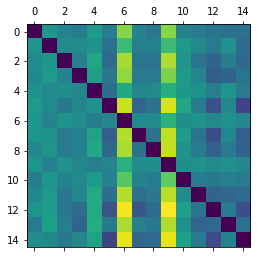

In [43]:
plt.matshow(distance_df)

Finding the most common tags between cuisines that are similar 

In [60]:
a = set(cuisine_adj_mat.loc["Thai", :].sort_values(ascending=False).head(10).index)

b = set(cuisine_adj_mat.loc["Barbeque", :].sort_values(ascending=False).head(10).index)

c = set(cuisine_adj_mat.loc["Mexican", :].sort_values(ascending=False).head(10).index)

a.intersection(b).intersection(c)

{'Bars', 'Chinese', 'Nightlife'}